In [124]:
import torch 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
import torch_geometric as pyg 
import seaborn as sbn
import networkx as nx 
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import pickle as pkl 
from sklearn.metrics import r2_score
from adjustText import adjust_text
import os 
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import gseapy
import statsmodels.formula.api as sm

import sys 
sys.path.append('../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset
from src.interpret.model_comparison_utils import plot_model2model_comparison, grouped_performance_rowwise, model_comp_performance_by_gene

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gsnn_root = '../output/from_exacloud/exp1/GSNN/'
nn_root = '../output/from_exacloud/exp1/NN/'
gsnn_rand_root = '../output/from_exacloud/exp1/GSNN_RAND/'

data_path = '../output/from_exacloud/exp1/proc/'
out_path = '../output/from_exacloud/exp1/'

In [3]:
gsnn_paths = [gsnn_root + '/' + fold + '/' + [x for x in os.listdir(gsnn_root + '/' + fold) if 'model' in x][0] for fold in os.listdir(gsnn_root)]
nn_paths = [nn_root + '/' + fold + '/' + [x for x in os.listdir(nn_root + '/' + fold) if 'model' in x][0] for fold in os.listdir(nn_root)]
gsnn_rand_paths = [gsnn_rand_root + '/' + fold + '/' + [x for x in os.listdir(gsnn_rand_root + '/' + fold) if 'model' in x][0] for fold in os.listdir(gsnn_rand_root)]

print('# GSNN models', len(gsnn_paths))
print('# NN models', len(nn_paths))
print('# GSNN (rand) models', len(gsnn_rand_paths))

# GSNN models 3
# NN models 3
# GSNN (rand) models 3


In [4]:
gsnn_paths[0]

'../output/from_exacloud/exp1/GSNN//FOLD-3/model-90.pt'

In [136]:
siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t', low_memory=False)
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_symbol'}, axis=1)
geneinfo = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')


In [6]:
data = torch.load(data_path + '/Data.pt')
#all_ids = np.load(data_path + '/lincs_train_obs.npy', allow_pickle=True).tolist() + np.load(data_path + '/lincs_test_obs.npy', allow_pickle=True).tolist() + np.load(data_path + '/lincs_val_obs.npy', allow_pickle=True).tolist()
#sig_ids = np.load(data_path + '/sig_ids.npy', allow_pickle=True).tolist()
#dataset = LincsDataset(data_path, sig_ids, data, null_inflation=0.)
#loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=False, num_workers=8)

In [7]:
RECOMPUTE_PREDICTIONS = True

if RECOMPUTE_PREDICTIONS: 

    gsnn_rand_predictions = []
    for  path in gsnn_rand_paths: 
        model = torch.load(path).eval().cuda()
        test_ids = np.load('/'.join(path.split('/')[:-1]) + '/lincs_test_obs.npy', allow_pickle=True)
        dataset = LincsDataset(data_path, test_ids, data, null_inflation=0.)
        loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=False, num_workers=8)
        y, yhat, sig_ids = utils.predict_gsnn(loader, model, data, device='cuda', return_omics=False)
        gsnn_rand_predictions.append({'y':y, 'yhat':yhat, 'sig_ids':sig_ids})

    gsnn_predictions = []
    for  path in gsnn_paths: 
        model = torch.load(path).eval().cuda()
        test_ids = np.load('/'.join(path.split('/')[:-1]) + '/lincs_test_obs.npy', allow_pickle=True)
        dataset = LincsDataset(data_path, test_ids, data, null_inflation=0.)
        loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=False, num_workers=8)
        y, yhat, sig_ids = utils.predict_gsnn(loader, model, data, device='cuda', return_omics=False)
        gsnn_predictions.append({'y':y, 'yhat':yhat, 'sig_ids':sig_ids})

    nn_predictions = []
    for path in nn_paths: 
        model = torch.load(path).eval().cuda()
        test_ids = np.load('/'.join(path.split('/')[:-1]) + '/lincs_test_obs.npy', allow_pickle=True)
        dataset = LincsDataset(data_path, test_ids, data, null_inflation=0.)
        loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=False, num_workers=8)
        y, yhat, sig_ids = utils.predict_nn(loader, model, data, device='cuda')
        nn_predictions.append({'y':y, 'yhat':yhat, 'sig_ids':sig_ids})

    with open(out_path + '/gsnn_TEST_predictions.pkl', 'wb') as f: 
        pkl.dump(gsnn_predictions, f)

    with open(out_path + '/nn_TEST_predictions.pkl', 'wb') as f: 
        pkl.dump(nn_predictions, f)

    with open(out_path + '/gsnn_TEST_rand_predictions.pkl', 'wb') as f: 
        pkl.dump(gsnn_rand_predictions, f)

else: 
    with open(out_path + '/gsnn_TEST_predictions.pkl', 'rb') as f: 
        gsnn_predictions = pkl.load(f)

    with open(out_path + '/nn_TEST_predictions.pkl', 'rb') as f: 
        nn_predictions = pkl.load(f)

    with open(out_path + '/gsnn_TEST_rand_predictions.pkl', 'rb') as f: 
        gsnn_rand_predictions = pkl.load(f)





# Performance by `drug`

In [105]:
groups_list = [] 
for nn_preds, gsnn_preds in zip(nn_predictions, gsnn_predictions): 
    assert (np.array(nn_preds['sig_ids']) == np.array(gsnn_preds['sig_ids'])).all(), 'sig ids do not match'
    siginfo_ = pd.DataFrame({'sig_id':gsnn_preds['sig_ids']}).merge(siginfo, on='sig_id', how='left').reset_index()
    drug_groups = {p:siginfo_[lambda x: x.pert_id == p].index.values for p in siginfo_.pert_id.unique()}
    groups_list.append(drug_groups)

In [106]:

res = grouped_performance_rowwise(groups_list, 
                            model1_preds=gsnn_predictions, 
                            model2_preds=nn_predictions, 
                            metric='pearson', 
                            test='paired_ttest',
                            min_members_per_group=5, 
                            min_num_replicates_per_drug=3,
                            pval_adj_method='fdr_bh')

res = res.merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='group', right_on='pert_id', how='left')

computing row-wise groups (e.g., obs groupings)


/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


progress: 367/368 [replicate: 2]
# failed groups (too few obs per group): 271


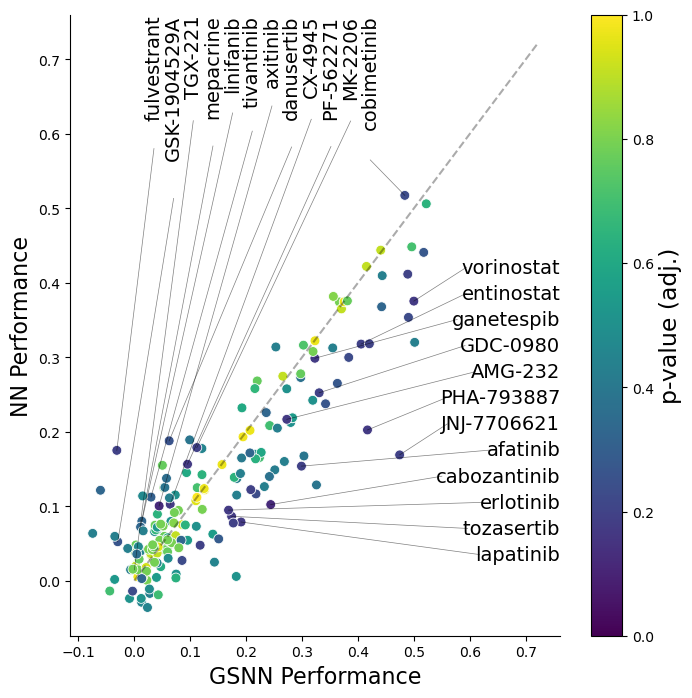

In [107]:
plot_model2model_comparison(res, 
                            'cmap_name', 
                            12, 
                            12, 
                            model1_name='GSNN', 
                            model2_name='NN',
                            fontsize=14, 
                            leaderline_magic_scalar=0.17)

In [ ]:
# rand gsnn vs gsnn 


In [100]:
groups_list = [] 
for gsnn_rand_preds, gsnn_preds in zip(gsnn_rand_predictions, gsnn_predictions): 
    assert (np.array(gsnn_rand_preds['sig_ids']) == np.array(gsnn_preds['sig_ids'])).all(), 'sig ids do not match'
    siginfo_ = pd.DataFrame({'sig_id':gsnn_preds['sig_ids']}).merge(siginfo, on='sig_id', how='left').reset_index()
    drug_groups = {p:siginfo_[lambda x: x.pert_id == p].index.values for p in siginfo_.pert_id.unique()}
    groups_list.append(drug_groups)

In [101]:
res = grouped_performance_rowwise(groups_list, 
                            model1_preds=gsnn_predictions, 
                            model2_preds=gsnn_rand_predictions, 
                            metric='pearson', 
                            test='paired_ttest',
                            min_members_per_group=5, 
                            min_num_replicates_per_drug=3,
                            pval_adj_method='fdr_bh')

res = res.merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='group', right_on='pert_id', how='left')

computing row-wise groups (e.g., obs groupings)
progress: 367/368 [replicate: 2]
# failed groups (too few obs per group): 271


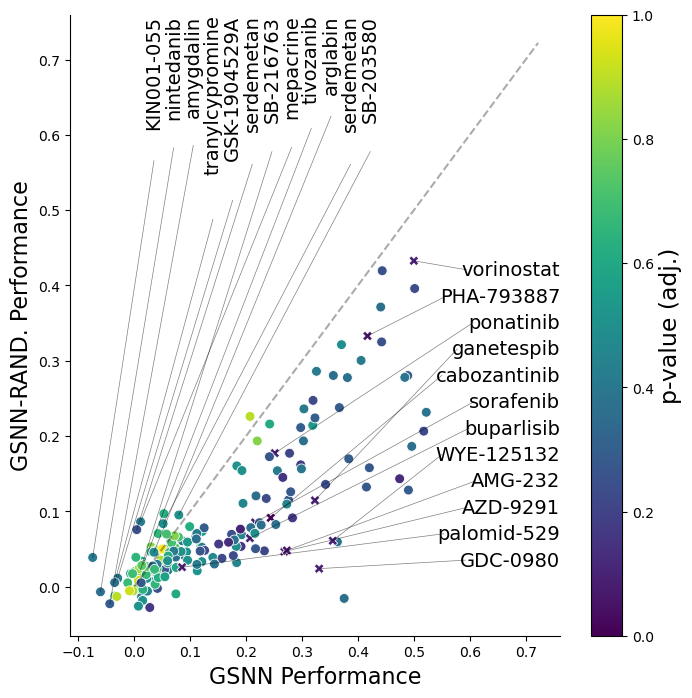

In [104]:
plot_model2model_comparison(res, 
                            'cmap_name', 
                            12, 
                            12, 
                            model1_name='GSNN', 
                            model2_name='GSNN-RAND.',
                            fontsize=14, 
                            leaderline_magic_scalar=0.17)

# performance by `drug target`

In [108]:
def get_targ_groupings(siginfo, sigids): 

    siginfo2 = siginfo.merge(pd.DataFrame({'sig_id':sigids}), how='right').reset_index()

    src,dst = data.node_names[data.edge_index]
    drug_targ = pd.DataFrame({'src':src, 'dst':dst})[lambda x: x.src.str.contains('DRUG__')]
    drug_targ = drug_targ.assign(pert_id = [x.split('__')[1] for x in drug_targ.src.values], 
                                uniprot = [x.split('__')[1] for x in drug_targ.dst.values])
    uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_symbol'}, axis=1)
    drug_targ = drug_targ.merge(uni2symb, on='uniprot', how='left')

    targ_dict = {}
    targspace = drug_targ.uniprot.unique()
    for i,targ in enumerate(targspace): 
        drugs_with_targ = drug_targ[lambda x: x.uniprot == targ].pert_id.unique().tolist()
        idx = siginfo2[lambda x: x.pert_id.isin(drugs_with_targ)].index
        targ_dict[targ] = idx 

    return targ_dict 

In [109]:
groups_list = [] 
for nn_preds, gsnn_preds in zip(gsnn_rand_predictions, gsnn_predictions): 
    assert (np.array(nn_preds['sig_ids']) == np.array(gsnn_preds['sig_ids'])).all(), 'sig ids do not match'
    targ_groups = get_targ_groupings(siginfo, sigids=gsnn_preds['sig_ids'])
    groups_list.append(targ_groups)

In [110]:
res = grouped_performance_rowwise(groups_list, 
                            model1_preds=gsnn_predictions, 
                            model2_preds=nn_predictions, 
                            metric='pearson', 
                            test='paired_ttest',
                            min_members_per_group=5, 
                            min_num_replicates_per_drug=3,
                            pval_adj_method='fdr_by')

res = res.merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='group', right_on='pert_id', how='left')
res = res.merge(uni2symb, left_on='group', right_on='uniprot', how='left')


computing row-wise groups (e.g., obs groupings)
progress: 133/134 [replicate: 2]
# failed groups (too few obs per group): 26


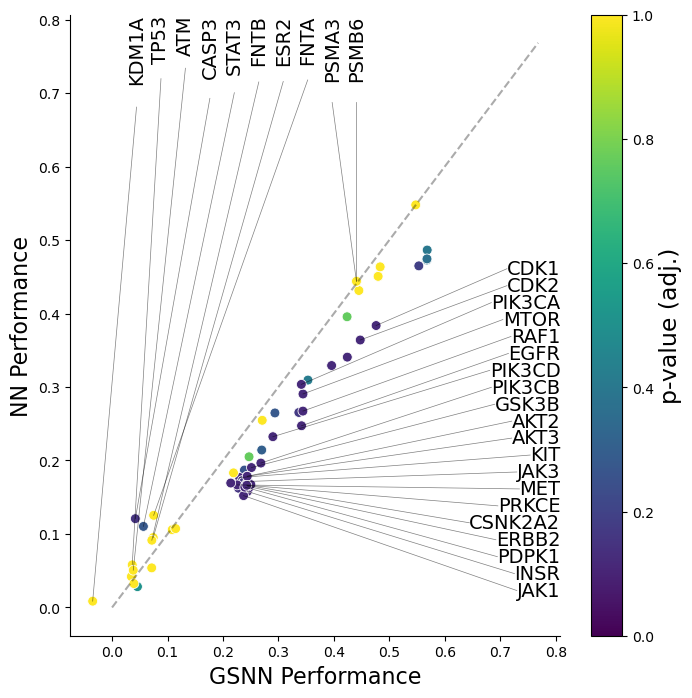

In [114]:
plot_model2model_comparison(res, 
                            'gene_symbol', 
                            10, 
                            20, 
                            model1_name='GSNN', 
                            model2_name='NN',
                            fontsize=14, 
                            leaderline_magic_scalar=0.18)

In [ ]:
# gsnn vs rand 

In [115]:
groups_list = [] 
for gsnn_rand_preds, gsnn_preds in zip(gsnn_rand_predictions, gsnn_predictions): 
    assert (np.array(gsnn_rand_preds['sig_ids']) == np.array(gsnn_preds['sig_ids'])).all(), 'sig ids do not match'
    targ_groups = get_targ_groupings(siginfo, sigids=gsnn_preds['sig_ids'])
    groups_list.append(targ_groups)

In [121]:
res = grouped_performance_rowwise(groups_list, 
                            model1_preds=gsnn_predictions, 
                            model2_preds=gsnn_rand_predictions, 
                            metric='pearson', 
                            test='paired_ttest',
                            min_members_per_group=5, 
                            min_num_replicates_per_drug=3,
                            pval_adj_method='fdr_by')

res = res.merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='group', right_on='pert_id', how='left')
res = res.merge(uni2symb, left_on='group', right_on='uniprot', how='left')


computing row-wise groups (e.g., obs groupings)
progress: 133/134 [replicate: 2]
# failed groups (too few obs per group): 26


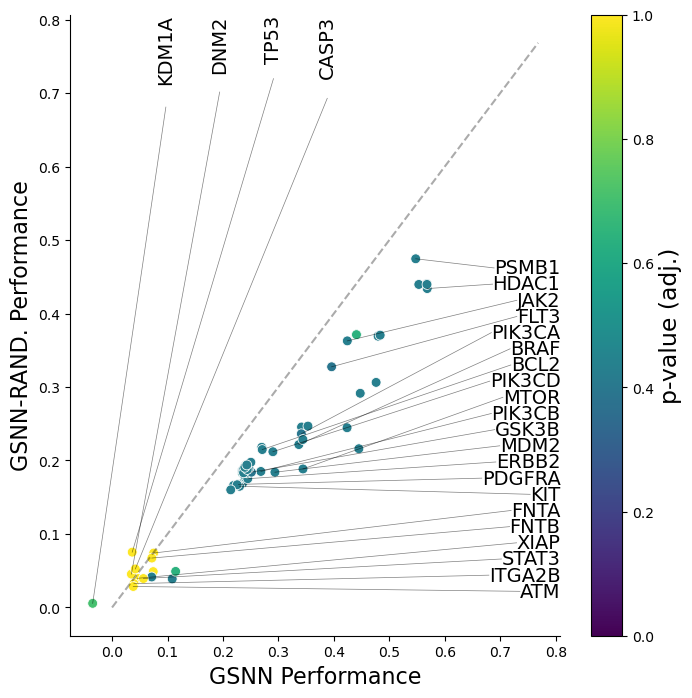

In [122]:
plot_model2model_comparison(res, 
                            'gene_symbol', 
                            10, 
                            15, 
                            model1_name='GSNN', 
                            model2_name='GSNN-RAND.',
                            fontsize=14, 
                            leaderline_magic_scalar=0.18)

# performance by `gene`

In [140]:
res = model_comp_performance_by_gene(model1_preds=gsnn_predictions, 
                                     model2_preds=nn_predictions, 
                                     gene_names = [x.split('__')[1] for x in data.node_names[data.output_node_mask]], 
                                     pval_adj_method='fdr_bh')
res = res.merge(geneinfo, left_on='group', right_on='From', how='left')
res = res.rename({'To':'Gene'}, axis=1)
res.head()

computing gene-wise performances


,group,model1_mean_perf,model2_mean_perf,model1_std_perf,model2_std_perf,pval,tstat,mean_diff_perf,std_diff_perf,ci_diff_perf,pval_adj,From,Gene
0,O00180,0.400724,0.368770,0.077743,0.061327,0.131383,2.479216,0.031955,0.018228,"[0.015053387510567456, 0.055483245507853496]",0.247985,O00180,KCNK1
1,O00206,0.396668,0.367627,0.062643,0.062991,0.054042,4.125298,0.029041,0.009956,"[0.02039237074139009, 0.0420025736883401]",0.168874,O00206,TLR4
2,O00214,0.483417,0.465971,0.036884,0.036004,0.059220,3.924452,0.017447,0.006287,"[0.009346154894455755, 0.02333617586471966]",0.175144,O00214,LGALS8
3,O00233,0.463887,0.465569,0.073262,0.055334,0.909972,-0.127838,-0.001682,0.018611,"[-0.021064094572033606, 0.02158549226989116]",0.936857,O00233,PSMD9
4,O00273,0.665087,0.651839,0.039619,0.041126,0.189207,1.958942,0.013248,0.009564,"[0.000725148476454568, 0.020681683568781927]",0.305116,O00273,DFFA


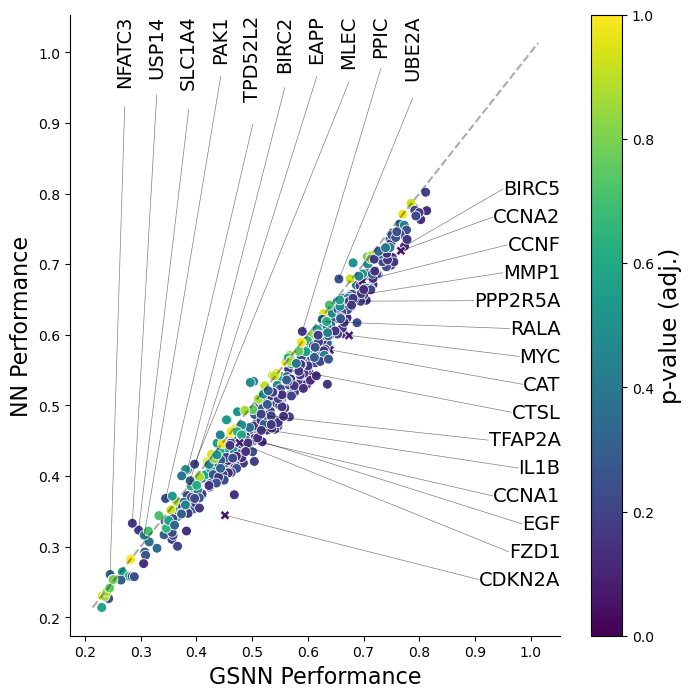

In [141]:
plot_model2model_comparison(res, 
                            'Gene', 
                            10, 
                            15, 
                            model1_name='GSNN', 
                            model2_name='NN',
                            fontsize=14, 
                            leaderline_magic_scalar=0.18)

In [ ]:
# GSNN vs rand 

In [142]:
res = model_comp_performance_by_gene(model1_preds=gsnn_predictions, 
                                     model2_preds=gsnn_rand_predictions, 
                                     gene_names = [x.split('__')[1] for x in data.node_names[data.output_node_mask]], 
                                     pval_adj_method='fdr_bh')
res = res.merge(geneinfo, left_on='group', right_on='From', how='left')
res = res.rename({'To':'Gene'}, axis=1)
res.head()

computing gene-wise performances


,group,model1_mean_perf,model2_mean_perf,model1_std_perf,model2_std_perf,pval,tstat,mean_diff_perf,std_diff_perf,ci_diff_perf,pval_adj,From,Gene
0,O00180,0.400724,0.352043,0.077743,0.050742,0.129406,2.502438,0.048681,0.027512,"[0.020346730744274462, 0.08322722059582771]",0.161080,O00180,KCNK1
1,O00206,0.396668,0.316855,0.062643,0.070452,0.010253,9.799702,0.079813,0.011518,"[0.06484091491078899, 0.08997117710887247]",0.088726,O00206,TLR4
2,O00214,0.483417,0.410672,0.036884,0.032404,0.002609,19.539632,0.072746,0.005265,"[0.06643538273457128, 0.07866376226380654]",0.088726,O00214,LGALS8
3,O00233,0.463887,0.348564,0.073262,0.064238,0.124838,2.558061,0.115323,0.063756,"[0.03183715684965088, 0.1627249524395761]",0.159300,O00233,PSMD9
4,O00273,0.665087,0.625401,0.039619,0.045039,0.009688,10.085813,0.039687,0.005565,"[0.0325560821489259, 0.04504009948334451]",0.088726,O00273,DFFA


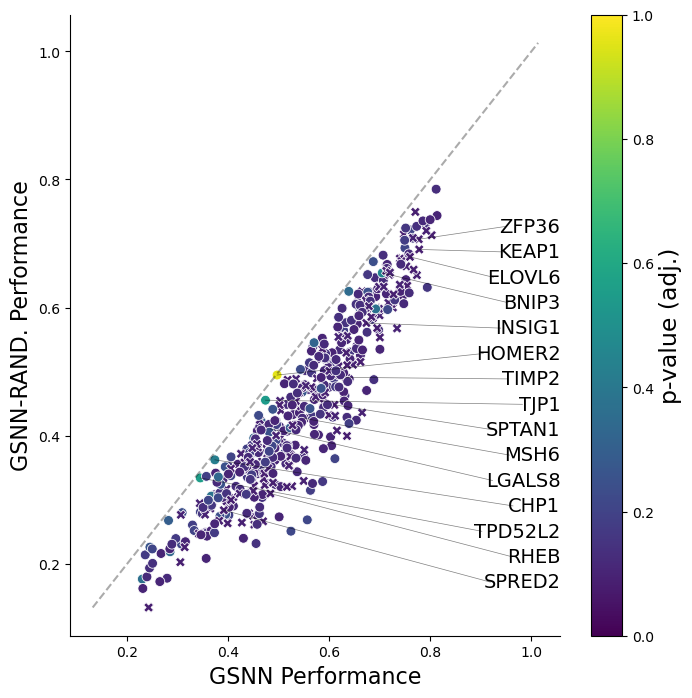

In [148]:
plot_model2model_comparison(res, 
                            'Gene', 
                            5, 
                            10, 
                            model1_name='GSNN', 
                            model2_name='GSNN-RAND.',
                            fontsize=14, 
                            leaderline_magic_scalar=0.18)

# peformance grouped by `target-in-pathway`

e.g., if an observation has a drug with a target in a given pathway... NOTE: this is very different than the next section 

computing row-wise groups
progress: 403/404
# failed groups (too few obs per group): 155


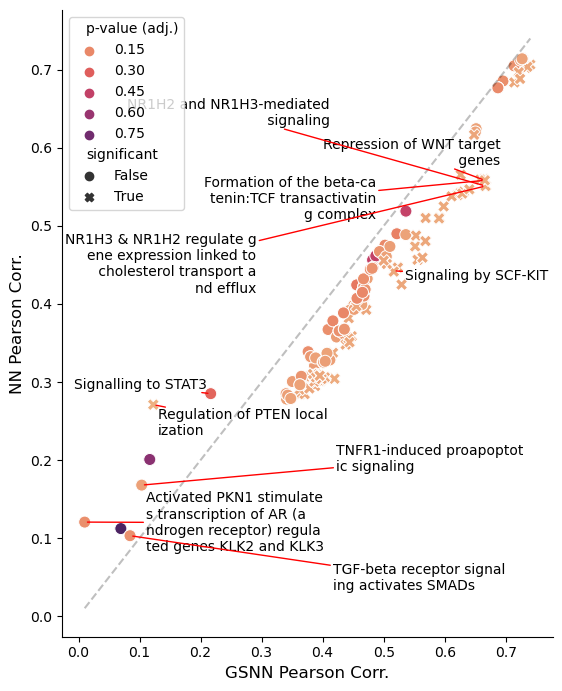

In [26]:
# reactome hiearchy 
dG = nx.from_pandas_edgelist(pd.read_csv('../../data/ReactomePathwaysRelation.txt', sep='\t', header=None).values.T, source=0, target=1, create_using=nx.DiGraph) 
pathspace = [x for x in nx.descendants(dG, 'R-HSA-162582')] # signaling by receptor tyrosine kinases: R-HSA-9006934

# uniprot -> reactome id 
pathways = pd.read_csv('../../data/UniProt2Reactome_All_Levels.txt', sep='\t', header=None)[[0,1,3,5]].rename({0:'uniprot', 1:'reactome_id', 3:'description', 5:'species'}, axis=1)
pathways = pathways[lambda x: x.species == 'Homo sapiens']
pathways = pathways[lambda x: x.reactome_id.isin(pathspace)]

# make groups 
targpath_dict = {} 
targspace = drug_targ.uniprot.unique()
pathspace = pathways.reactome_id.unique()
for path in pathspace: 
    targs_in_pathway = pathways[lambda x: (x.reactome_id == path) & (x.uniprot.isin(targspace))].uniprot.unique()
    drugs_targeting_pathway = drug_targ[lambda x: x.uniprot.isin(targs_in_pathway)].pert_id.values
    obs_with_drug_targ_in_pathway = siginfo2[lambda x: x.pert_id.isin(drugs_targeting_pathway)]
    targpath_dict[path] = obs_with_drug_targ_in_pathway.index.values 

# compute grouped performance 
pathtarg_res = grouped_performance(targpath_dict, gsnn_predictions, nn_predictions, axis=0, pval_adj_method='fdr_by', min_members_per_group=100)
pathtarg_res = pathtarg_res.merge(pathways[['reactome_id', 'description']].drop_duplicates(), left_on='group', right_on='reactome_id', how='left')

plot_model2model_comparison(pathtarg_res.assign(desc2 = lambda x: ['\n'.join(string[i:i+24] for i in range(0, len(string), 24)) for string in x.description]), 'desc2', 10,, 10, fontsize=10)

computing row-wise groups
progress: 403/404
# failed groups (too few obs per group): 155


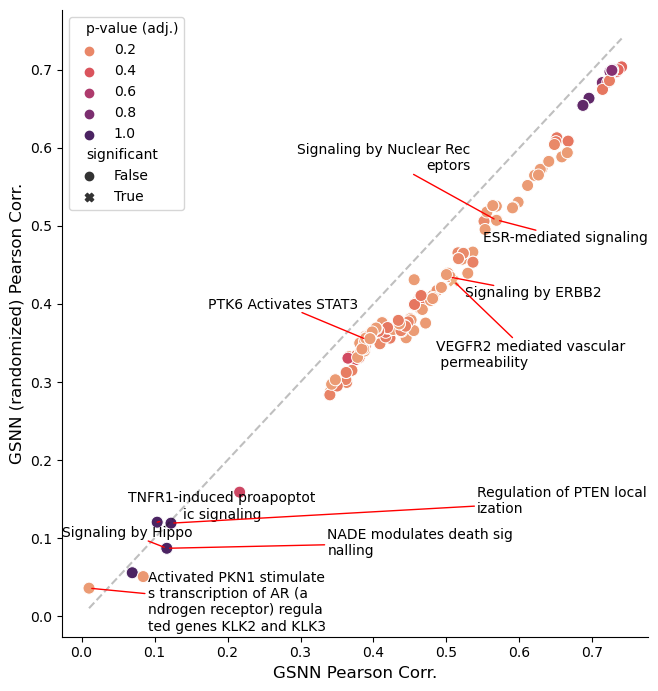

In [27]:
pathtarg_res_rand = grouped_performance(targpath_dict, gsnn_predictions, gsnn_rand_predictions, axis=0, pval_adj_method='fdr_by', min_members_per_group=100)
pathtarg_res_rand = pathtarg_res_rand.merge(pathways[['reactome_id', 'description']].drop_duplicates(), left_on='group', right_on='reactome_id', how='left')

plot_model2model_comparison(pathtarg_res_rand.assign(desc2 = lambda x: ['\n'.join(string[i:i+24] for i in range(0, len(string), 24)) for string in x.description]), 'desc2', 10, fontsize=10, model2_name='GSNN (randomized)')

computing row-wise groups
progress: 403/404
# failed groups (too few obs per group): 155


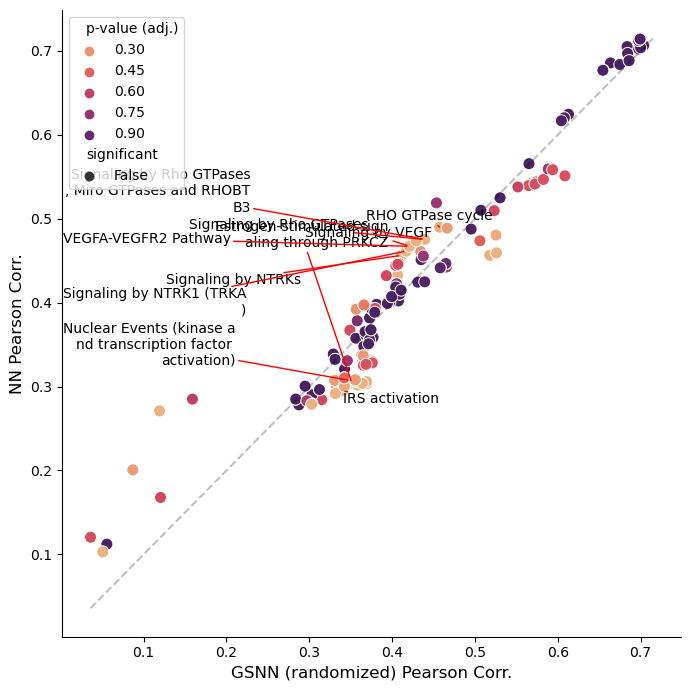

In [ ]:
pathtarg_res_rand = grouped_performance(targpath_dict, gsnn_rand_predictions, nn_predictions, axis=0, pval_adj_method='fdr_by', min_members_per_group=100)
pathtarg_res_rand = pathtarg_res_rand.merge(pathways[['reactome_id', 'description']].drop_duplicates(), left_on='group', right_on='reactome_id', how='left')

plot_model2model_comparison(pathtarg_res_rand.assign(desc2 = lambda x: ['\n'.join(string[i:i+24] for i in range(0, len(string), 24)) for string in x.description]), 'desc2', 10, fontsize=10, model1_name='GSNN (randomized)')

In [ ]:
path_res2 = {'reactome_id':[], 'prop_proteins':[], 'prop_rnas':[], 'prop_lincs':[], 'prop_targs':[], 'path_size':[]}

GSNN_proteins = [x.split('__')[1] for x in data.node_names if 'PROTEIN__' in x]
GSNN_rnas = [x.split('__')[1] for x in data.node_names if 'RNA__' in x]
GSNN_lincs = [x.split('__')[1] for x in data.node_names if 'LINCS__' in x]

for i,path in enumerate(pathspace): 
    print(f'progress: {i}/{len(pathspace)}', end='\r')
    tmp = pathways[lambda x: x.reactome_id == path]
    full_pathway = set(tmp.uniprot.unique().tolist()) 
    prots_in_pathway = set(GSNN_proteins).intersection(full_pathway)
    rnas_in_pathway = set(GSNN_rnas).intersection(full_pathway)
    lincs_in_pathway = set(GSNN_lincs).intersection(full_pathway)
    targs_in_pathway = set(targspace).intersection(full_pathway)

    path_res2['reactome_id'].append(path)
    path_res2['prop_proteins'].append(len(prots_in_pathway) / len(full_pathway))
    path_res2['prop_rnas'].append(len(rnas_in_pathway) / len(full_pathway))
    path_res2['prop_lincs'].append(len(lincs_in_pathway) / len(full_pathway))
    path_res2['prop_targs'].append(len(targs_in_pathway) / len(full_pathway))
    path_res2['path_size'].append(len(full_pathway))

path_res2 = pd.DataFrame(path_res2)
path_res2.head()

,reactome_id,prop_proteins,prop_rnas,prop_lincs,prop_targs,path_size
0,R-HSA-194315,0.096012,0.097489,0.056130,0.025111,677
1,R-HSA-9012999,0.079646,0.070796,0.042035,0.017699,452
2,R-HSA-9013106,0.080000,0.080000,0.040000,0.013333,75
3,R-HSA-9716542,0.093795,0.095238,0.054834,0.024531,693
4,R-HSA-9696270,0.116279,0.093023,0.023256,0.000000,43


In [ ]:
pathtarg_res2 = pathtarg_res.merge(path_res2, on='reactome_id')

In [ ]:
pathtarg_res2[['mean_diff_r', 'tstat', 'prop_proteins', 'prop_lincs', 'prop_rnas', 'prop_targs']].corr('pearson')

,mean_diff_r,tstat,prop_proteins,prop_lincs,prop_rnas,prop_targs
mean_diff_r,1.000000,0.577739,-0.014439,0.126683,0.180542,0.005458
tstat,0.577739,1.000000,-0.103307,0.021718,-0.054262,-0.042254
prop_proteins,-0.014439,-0.103307,1.000000,0.157999,0.614487,0.679177
prop_lincs,0.126683,0.021718,0.157999,1.000000,0.597542,0.229149
prop_rnas,0.180542,-0.054262,0.614487,0.597542,1.000000,0.598530
prop_targs,0.005458,-0.042254,0.679177,0.229149,0.598530,1.000000


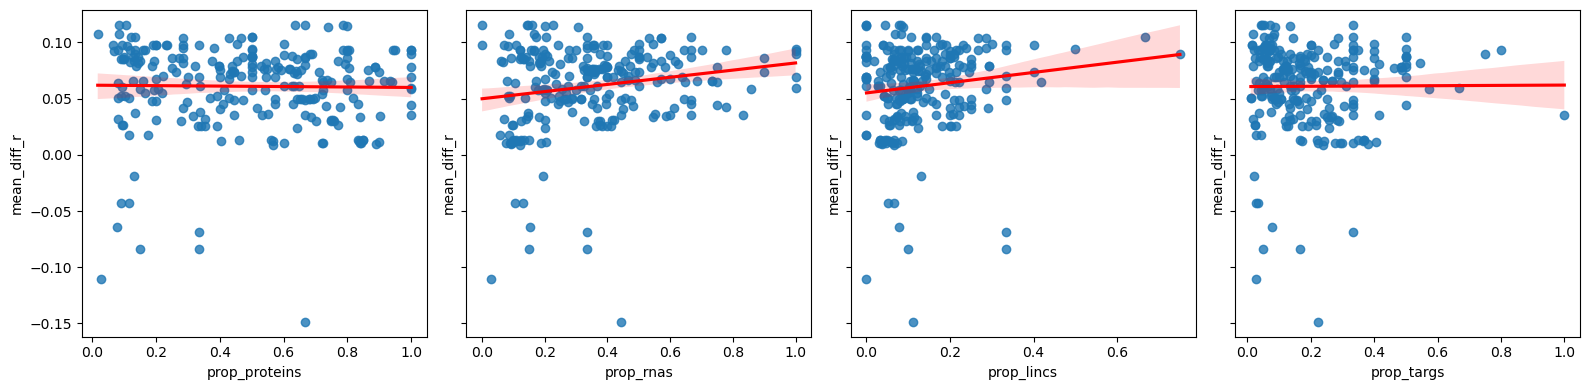

In [ ]:
__metric__ = 'mean_diff_r'
f, axes = plt.subplots(1,4,figsize=(4*4, 4), sharey=True)
sbn.regplot(x='prop_proteins', y=__metric__, data=pathtarg_res2, line_kws={'color':'r'}, ax=axes.flat[0])
sbn.regplot(x='prop_rnas', y=__metric__, data=pathtarg_res2, line_kws={'color':'r'}, ax=axes.flat[1])
sbn.regplot(x='prop_lincs', y=__metric__, data=pathtarg_res2, line_kws={'color':'r'}, ax=axes.flat[2])
sbn.regplot(x='prop_targs', y=__metric__, data=pathtarg_res2, line_kws={'color':'r'}, ax=axes.flat[3])
#plt.xlabel('proportion of LINCS genes (in GSNN) in pathway')
#plt.ylabel('GSNN prediction advantage (diff. in corr.)')
plt.tight_layout()
plt.show()

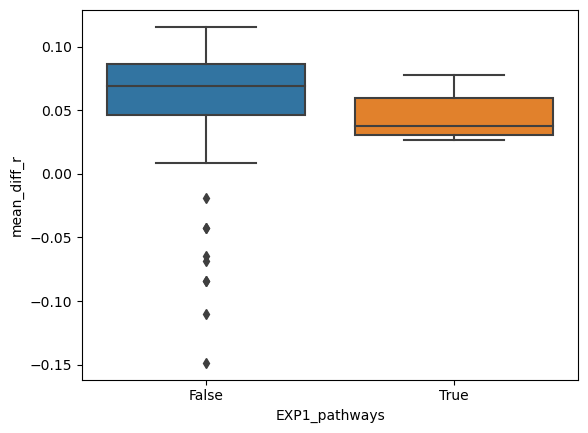

In [ ]:
pathtarg_res2 = pathtarg_res2.assign(EXP1_pathways = lambda x: x.group.isin('R-HSA-177929 R-HSA-1489509 R-HSA-1257604 R-HSA-5673001 R-HSA-1227986 R-HSA-109606 R-HSA-6806003 R-HSA-202131 R-HSA-6807070 R-HSA-6807070 R-HSA-5673001'.split(' ')))

plt.figure()
sbn.boxplot(x='EXP1_pathways', y='mean_diff_r', data=pathtarg_res2)
plt.show()

# performance by `cell line`

In [99]:
cell_dict = {} 
cellspace = siginfo2.cell_iname.unique()
for i, cell in enumerate(cellspace): 
    cell_dict[cell] = siginfo2[lambda x: x.cell_iname == cell].index.values 

cell_res = grouped_performance(cell_dict, gsnn_predictions, nn_predictions, min_members_per_group=100)
   

computing row-wise groups
progress: 79/80
# failed groups (too few obs per group): 18


/home/teddy/local/GSNN/notebooks/../src/interpret/model_comparison_utils.py:192: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sbn.scatterplot(x='gsnn_mean_r', y='nn_mean_r', size=size, style='significant', legend=False, data=res, c='k', marker='.', s=markersize, palette=sbn.color_palette("flare", as_cmap=True), ax=ax)


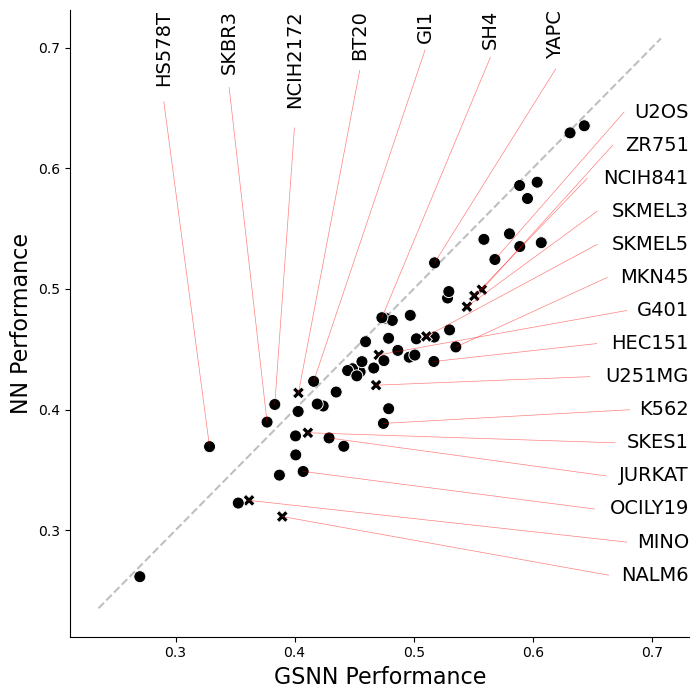

In [100]:
plot_model2model_comparison(cell_res, 'group', 7, 15, fontsize=14, leaderline_magic_scalar=.1)

computing row-wise groups
progress: 79/80
# failed groups (too few obs per group): 0


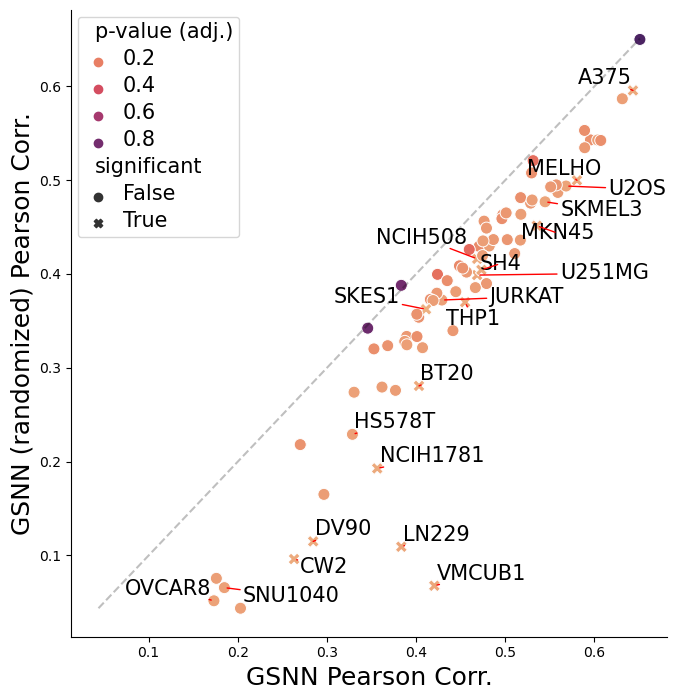

In [ ]:
cell_res_rand = grouped_performance(cell_dict, gsnn_predictions, gsnn_rand_predictions)
plot_model2model_comparison(cell_res_rand, 'group', 20, model2_name='GSNN (randomized)')

# performance by `disease`

In [101]:
cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')

dis_dict = {} 
disspace = cellinfo.primary_disease.unique()
for i, dis in enumerate(disspace): 
    print(f'progress: {i}/{len(disspace)}', end='\r')
    cells_in_disease = cellinfo[lambda x: x.primary_disease == dis].cell_iname.unique()
    dis_dict[dis] = siginfo2[lambda x: x.cell_iname.isin(cells_in_disease)].index.values

dis_res = grouped_performance(dis_dict, gsnn_predictions, nn_predictions, min_members_per_group=100, pval_adj_method='fdr_bh')



computing row-wise groups
progress: 26/27
# failed groups (too few obs per group): 8


/home/teddy/local/GSNN/notebooks/../src/interpret/model_comparison_utils.py:192: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sbn.scatterplot(x='gsnn_mean_r', y='nn_mean_r', size=size, style='significant', legend=False, data=res, c='k', marker='.', s=markersize, palette=sbn.color_palette("flare", as_cmap=True), ax=ax)


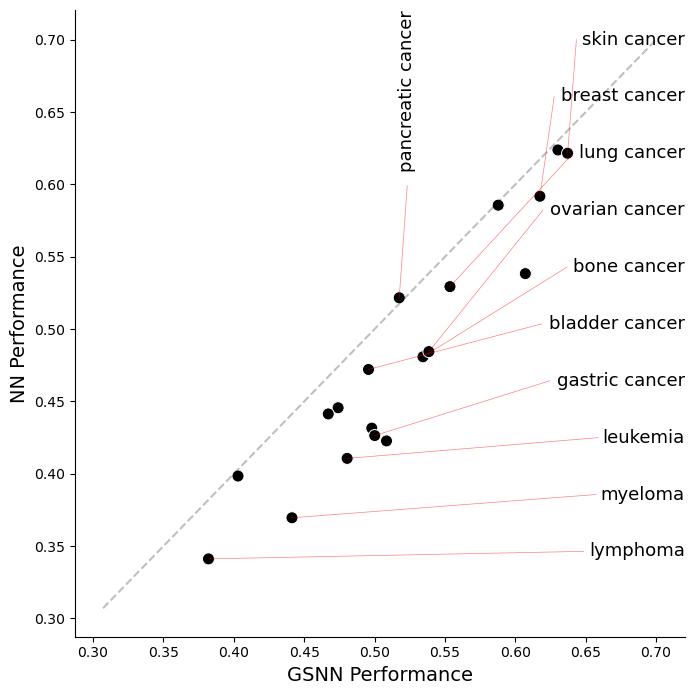

In [118]:
plot_model2model_comparison(dis_res, 'group', 1, 10, fontsize=13, leaderline_magic_scalar=0.075)

computing row-wise groups
progress: 26/27
# failed groups (too few obs per group): 8


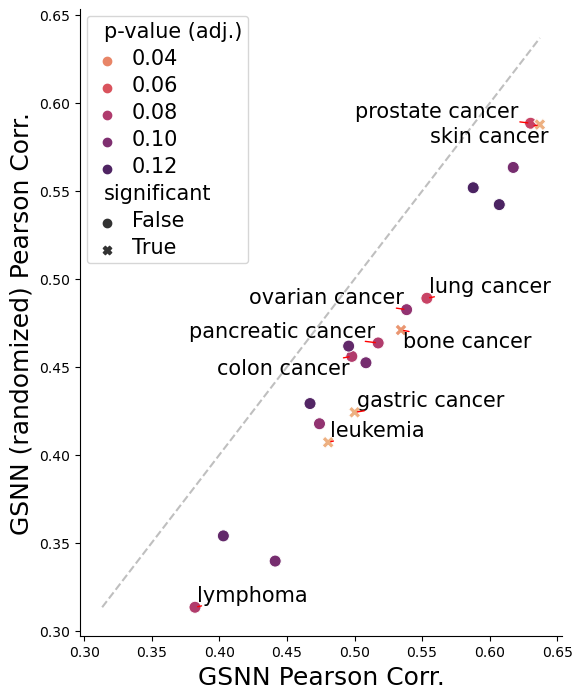

In [ ]:
dis_res_rand = grouped_performance(dis_dict, gsnn_predictions, gsnn_rand_predictions, min_members_per_group=100)
plot_model2model_comparison(dis_res_rand, 'group', 10, model2_name='GSNN (randomized)')

# Performance grouped by `dose`

In [157]:
groups_list = [] 
for nn_preds, gsnn_preds in zip(nn_predictions, gsnn_predictions): 
    assert (np.array(nn_preds['sig_ids']) == np.array(gsnn_preds['sig_ids'])).all(), 'sig ids do not match'
    siginfo_ = pd.DataFrame({'sig_id':gsnn_preds['sig_ids']}).merge(siginfo, on='sig_id', how='left').reset_index()
    drug_groups = {dose:siginfo_[lambda x: x.pert_dose == dose].index.values for dose in siginfo_.pert_dose.unique()}
    groups_list.append(drug_groups)

In [161]:

res = grouped_performance_rowwise(groups_list, 
                            model1_preds=gsnn_predictions, 
                            model2_preds=nn_predictions, 
                            metric='pearson', 
                            test='paired_ttest',
                            min_members_per_group=50, 
                            min_num_replicates_per_drug=3,
                            pval_adj_method='fdr_bh')


computing row-wise groups (e.g., obs groupings)
progress: 166/167 [replicate: 2]
# failed groups (too few obs per group): 223


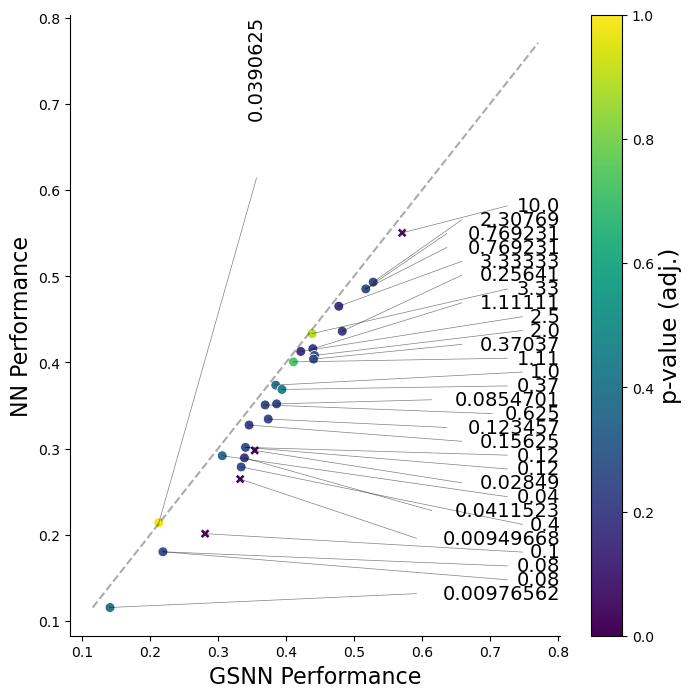

In [162]:
plot_model2model_comparison(res, 
                            'group', 
                            10, 
                            20, 
                            model1_name='GSNN', 
                            model2_name='NN',
                            fontsize=14, 
                            leaderline_magic_scalar=0.18)

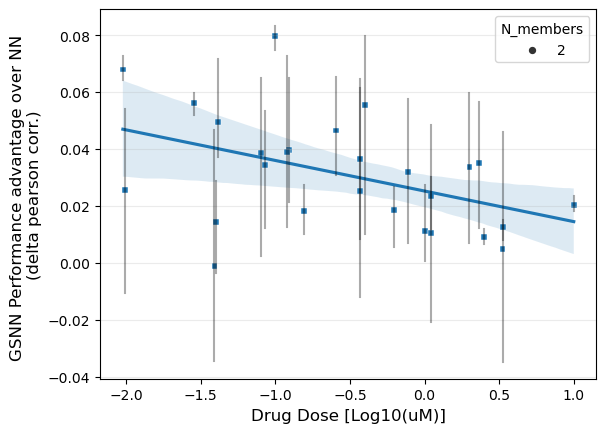

In [167]:
result = sm.ols(formula="mean_diff_perf ~  log_dose", data=res.assign(log_dose = [np.log10(float(x)) for x in res.group.values])).fit()

plt.figure()
sbn.regplot(x='log_dose', 
            y='mean_diff_perf', 
            data=res.assign(log_dose = [np.log10(float(x)) for x in res.group.values]), 
            scatter=False)

#scatter_kws={'color':'k', 's':[np.sqrt(x) for x in dose_res.N_members.values], 'marker':11}, 
#label=f'log10(dose) p-value: {result.pvalues.log_dose:.2E}\nr-squared: {result.rsquared:.2f}') 

for i,row in res.iterrows(): 
    plt.plot((np.log10(float(row.group)), np.log10(float(row.group))), ( row.ci_diff_perf[0], row.ci_diff_perf[1]), 'k-', alpha=0.33)

sbn.scatterplot(x='log_dose', 
                y='mean_diff_perf', 
                marker='s',
                size='N_members',
                s=50,
                data=res.assign(log_dose = [np.log10(float(x)) for x in res.group.values], 
                                     log_N = [np.log10(float(x)) for x in res.N_members.values]), alpha=1.)

plt.xlabel('Drug Dose [Log10(uM)]', fontsize=12)
plt.ylabel('GSNN Performance advantage over NN \n(delta pearson corr.)', fontsize=12)
plt.grid(which='major', axis='y', zorder=-1.0, alpha=0.25)
plt.show()

# Perfromance grouped by `metastis`

computing row-wise groups
progress: 3/4
# failed groups (too few obs per group): 0


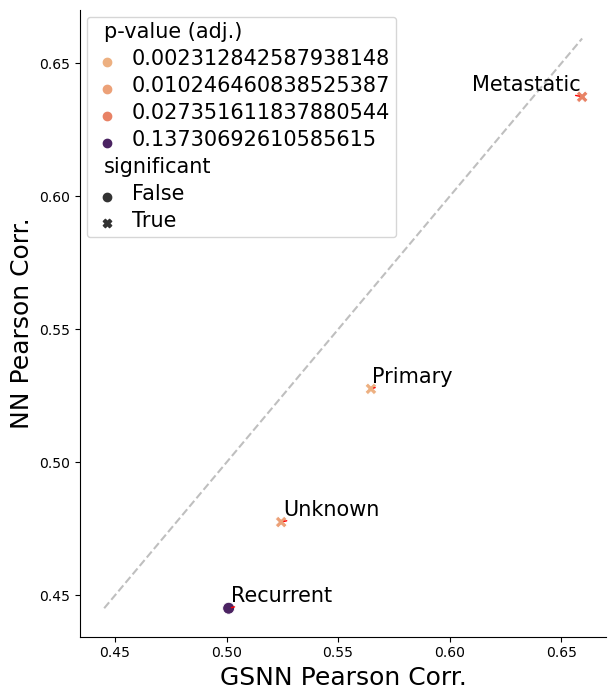

In [33]:
cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')

met_dict = {} 
metspace = cellinfo.donor_tumor_phase.unique()
for i, dis in enumerate(metspace): 
    print(f'progress: {i}/{len(metspace)}', end='\r')
    cells_in_phase = cellinfo[lambda x: x.donor_tumor_phase == dis].cell_iname.unique()
    met_dict[dis] = siginfo2[lambda x: x.cell_iname.isin(cells_in_phase)].index.values

met_res = grouped_performance(met_dict, gsnn_predictions, nn_predictions, min_members_per_group=100, pval_adj_method='fdr_bh')
plot_model2model_comparison(met_res, 'group', 10)

computing row-wise groups
progress: 2/3
# failed groups (too few obs per group): 0


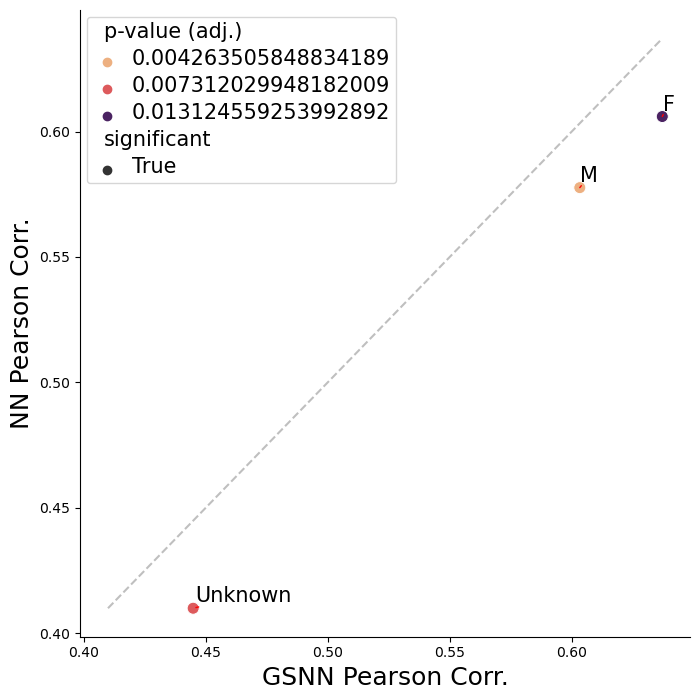

In [34]:
cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')

met_dict = {} 
metspace = cellinfo.donor_sex.unique()
for i, dis in enumerate(metspace): 
    print(f'progress: {i}/{len(metspace)}', end='\r')
    cells_in_phase = cellinfo[lambda x: x.donor_sex == dis].cell_iname.unique()
    met_dict[dis] = siginfo2[lambda x: x.cell_iname.isin(cells_in_phase)].index.values

met_res = grouped_performance(met_dict, gsnn_predictions, nn_predictions, min_members_per_group=0, pval_adj_method='fdr_bh')
plot_model2model_comparison(met_res, 'group', 10)

In [35]:
cellinfo.head()

,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
0,1HAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal fibroblast sample,NaN,unknown,NaN,NaN
1,AALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal epithelium sample,NaN,unknown,NaN,NaN
2,AG06263_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
3,AG06840_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
4,AG078N1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN


In [36]:
cellinfo.cell_type.unique()

array(['normal', 'tumor', 'pool'], dtype=object)

# GSNN advantage compared to target missingness

In [11]:
src,dst = data.node_names[data.edge_index]
edgeinfo = pd.DataFrame({'src':src, 'dst':dst})
G = nx.from_pandas_edgelist(edgeinfo, 'src', 'dst', create_using=nx.DiGraph)
edgeinfo[['src_type', 'src']] = edgeinfo['src'].str.split('__', expand=True)
edgeinfo[['dst_type', 'dst']] = edgeinfo['dst'].str.split('__', expand=True)
edgeinfo.head()

,src,dst,src_type,dst_type
0,P04637,P08069,PROTEIN,RNA
1,P40763,P38936,PROTEIN,RNA
2,P04637,P38936,PROTEIN,RNA
3,P04637,P06400,PROTEIN,RNA
4,Q01094,P38936,PROTEIN,RNA


In [12]:
targetome = pd.read_csv('../extdata/targetome_with_broad_ids.csv')[['pert_id', 'Target_UniProt']]
targetome.columns = ['pert_id', 'target']
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv',sep='\t')
uni2symb.columns = ['uniprot', 'gene_symbol']
druginfo2 = druginfo.merge(uni2symb, left_on='target', right_on='gene_symbol')[['pert_id', 'target']]
targinfo = pd.concat([targetome, druginfo2], axis=0).drop_duplicates()
targinfo.head()

,pert_id,target
0,BRD-K56343971,P04049
3,BRD-K56343971,P00533
4,BRD-K56343971,P15056
12,BRD-K03601870,Q13509
15,BRD-K03601870,P07437


In [13]:
targmiss = {'pert_id':[], 'num_targets_in_graph':[], 'num_known_targets':[], 'num_downstream_lincs':[]}

for drug in data.drugspace:
    targmiss['pert_id'].append(drug)
    targmiss['num_known_targets'].append( targinfo[['pert_id','target']].drop_duplicates()[lambda x: x.pert_id == drug].shape[0] )
    targmiss['num_targets_in_graph'].append( edgeinfo[lambda x: x.src == drug].shape[0] )
    targmiss['num_downstream_lincs'].append(len(set([x[1] for x in nx.algorithms.traversal.depth_first_search.dfs_edges(G, f"DRUG__{drug}", depth_limit=20) if 'LINCS' in x[1]])))
    

targmiss = pd.DataFrame(targmiss)
targmiss = targmiss.assign(num_missing_targets = lambda x: x.num_known_targets - x.num_targets_in_graph)
targmiss = targmiss.assign(prop_targets_in_graph = lambda x: x.num_targets_in_graph/ x.num_known_targets)
targmiss = targmiss.assign(prop_downstream_lincs = lambda x: x.num_downstream_lincs / data.output_node_mask.sum().item())
targmiss = targmiss.merge(drug_res, on='pert_id')
#targmiss = targmiss.merge(drug_res_rand, on='pert_id')
targmiss.head()

,pert_id,num_targets_in_graph,num_known_targets,num_downstream_lincs,num_missing_targets,prop_targets_in_graph,prop_downstream_lincs,group,gsnn_mean_r,nn_mean_r,gsnn_std_r,nn_std_r,pval,tstat,mean_diff_r,std_diff_r,ci_diff_r,N_members,pval_adj,cmap_name
0,BRD-A12230535,1,1,125,0,1.0,0.275938,BRD-A12230535,0.265391,0.170694,0.015642,0.006783,0.004848,14.309438,0.094697,0.009359,"[0.08245311746176459, 0.10222832891951712]",317,0.040563,nutlin-3
1,BRD-A13084692,1,1,265,0,1.0,0.584989,BRD-A13084692,0.182093,0.177979,0.039699,0.070407,0.871138,0.183770,0.004114,0.031656,"[-0.026895411665395524, 0.044497992219947075]",403,0.928921,troglitazone
2,BRD-A19500257,1,1,84,0,1.0,0.185430,BRD-A19500257,0.500744,0.485974,0.030061,0.031631,0.045705,4.515677,0.014770,0.004626,"[0.008712851103298757, 0.018217046396683752]",445,0.103482,geldanamycin
3,BRD-A45498368,1,1,237,0,1.0,0.523179,BRD-A45498368,0.427346,0.405547,0.019354,0.023729,0.020544,6.868813,0.021798,0.004488,"[0.01600866424223805, 0.025973998343245222]",171,0.067415,WYE-125132
4,BRD-A50998626,1,1,237,0,1.0,0.523179,BRD-A50998626,0.103980,0.086967,0.007697,0.011293,0.022792,6.510002,0.017013,0.003696,"[0.014089238496948845, 0.021851191720822984]",128,0.069398,palomid-529


In [16]:
targmiss.prop_downstream_lincs.mean()

0.43154893303899927

In [142]:
olsres = sm.ols('mean_diff_r ~  num_known_targets + num_missing_targets + prop_downstream_lincs', data=targmiss[lambda x: x.num_known_targets < 20]).fit()
olsres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mean_diff_r   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     11.60
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           1.25e-06
Time:                        15:11:06   Log-Likelihood:                 159.40
No. Observations:                 109   AIC:                            -310.8
Df Residuals:                     105   BIC:                            -300.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0635      0.023     -2.795      0.006      -0.109      -0.018
num_known_targets         0.0249      0.006      4.236      0.000       0.013       0.037
num_missing_targets      -0.0198      0.008     -2.493      0.014      -0.036      -0.004
prop_downstream_lincs     0.1173      0.042      2.794      0.006       0.034       0.201
==============================================================================
Omnibus:                       24.243   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.430
Skew:                           1.023   Prob(JB):                     7.45e-09
Kurtosis:                       5.015   Cond. No.                         39.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

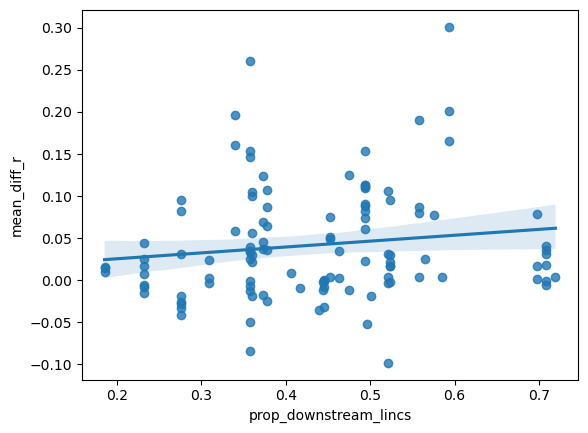

In [141]:
plt.figure()
sbn.regplot(x='prop_downstream_lincs', y='mean_diff_r', data=targmiss[lambda x: x.num_known_targets < 100])
plt.show()

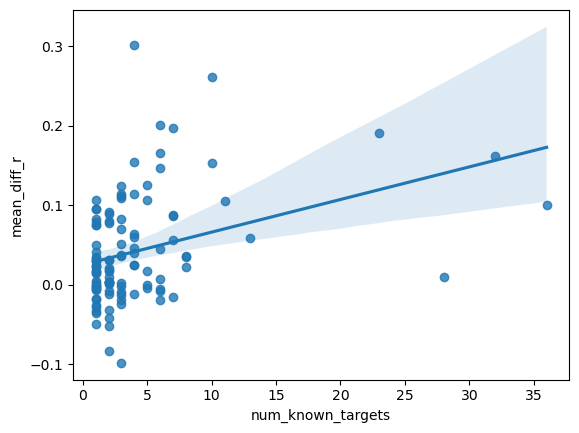

In [83]:
plt.figure()
sbn.regplot(x='num_known_targets', y='mean_diff_r', data=targmiss[lambda x: x.num_known_targets < 100])
plt.show()

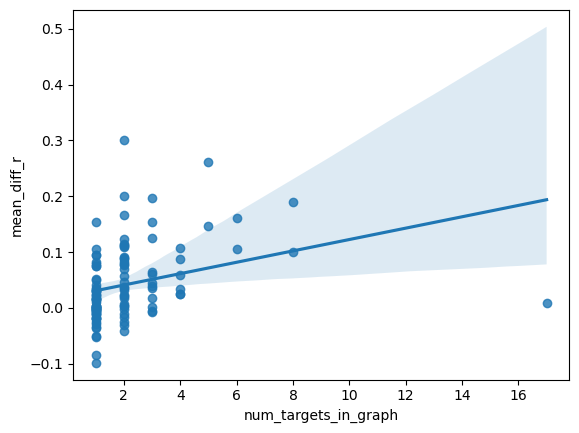

In [88]:
plt.figure()
sbn.regplot(x='num_targets_in_graph', y='mean_diff_r', data=targmiss[lambda x: x.num_known_targets < 100])
plt.show()

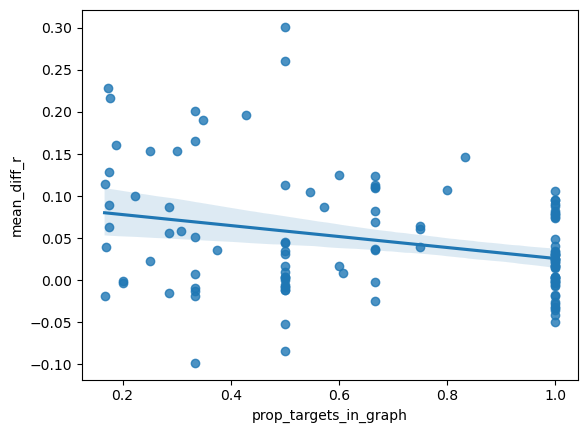

In [60]:
plt.figure()
sbn.regplot(x='prop_targets_in_graph', y='mean_diff_r', data=targmiss)
plt.show()

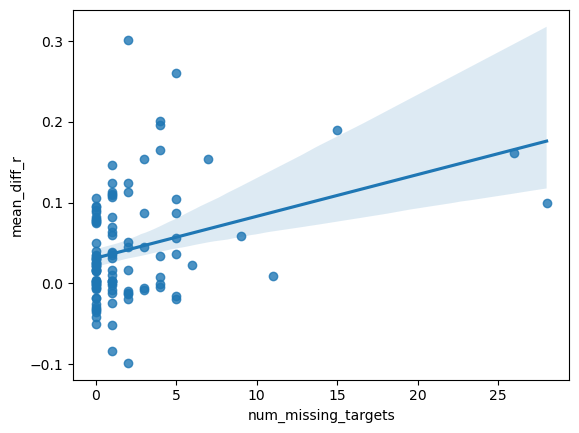

In [61]:
plt.figure()
sbn.regplot(x='num_missing_targets', y='mean_diff_r', data=targmiss[lambda x: x.num_known_targets < 100])
plt.show()